## Get outputs from each AlexNet layer to experiment images (using TF1)

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import h5py
import os

In [2]:
import tensorflow as tf

import sys
utils_dir = '/oak/stanford/groups/kalanit/biac2/kgs/projects/Dawn/NSD/code/fit_pipeline/utils/'
sys.path.append(utils_dir)

In [3]:
from general_utils import norm_image
from models_alexnet import alexnet
from models_alexnet import alexnet_wrapper

In [4]:
#setup paths
STIM_PATH = "../../../data/nsddata_stimuli/stimuli/nsd/"
CKPT_PATH = "../models/checkpoints/alexnet/model.ckpt-115000"

In [5]:
subjid = ["01", "02", "03", "04", "05", "06", "07", "08"]
n_repeats = 3

In [6]:
stim = h5py.File(STIM_PATH+'nsd_stimuli.hdf5','r') #73k images

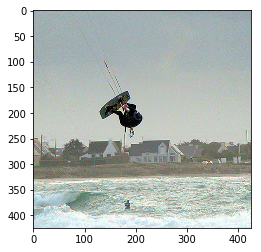

In [7]:
plt.imshow(stim['imgBrick'][0,:,:,:])

In [8]:
#okay let's get started
tf.reset_default_graph() #just in case

In [44]:
images = stim['imgBrick'][72974,:,:,:]/255.0 #minibatch to start

In [47]:
images.shape

(425, 425, 3)

In [49]:
#create image tensor
image_tensor = tf.convert_to_tensor(images, dtype=tf.float32)
resized_images = tf.image.resize_images(image_tensor, (224,224)) #to fit alexnet

#sanity check new images
with tf.Session() as sess:
    plt.imshow(sess.run(resized_images[0,:,:,:]))
    plt.colorbar()
    plt.show()

ValueError: Index out of range using input dim 3; input has only 3 dims for 'strided_slice_1' (op: 'StridedSlice') with input shapes: [224,224,3], [4], [4], [4] and with computed input tensors: input[3] = <1 1 1 1>.

In [50]:
model = alexnet(resized_images, train = False)

ValueError: Shape must be rank 4 but is rank 3 for 'Conv2D_35' (op: 'Conv2D') with input shapes: [224,224,3], [11,11,3,96].

In [12]:
print(model)

In [38]:
# initialize tf Session and restore weights
sess = tf.Session()
tf_saver = tf.train.Saver()
tf_saver.restore(sess, CKPT_PATH)

INFO:tensorflow:Restoring parameters from ../models/checkpoints/alexnet/model.ckpt-115000


In [39]:
conv1_weights_tensor = tf.get_default_graph().get_tensor_by_name("conv1/weights:0")
sanity_weights = sess.run(conv1_weights_tensor)
print(sanity_weights.shape)

(11, 11, 3, 96)


Text(0.5,1,'Filter 55')

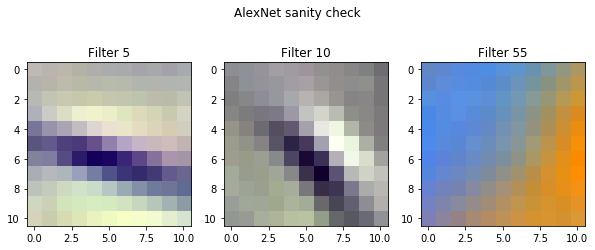

In [40]:
#plot select conv1 filters as sanity check
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10,4), nrows=1, ncols=3)
title = "AlexNet sanity check"
fig.suptitle(title)

true_filter_1 = norm_image(sanity_weights[:,:,:,5])
ax1.imshow(true_filter_1)
ax1.set_title("Filter 5")

true_filter_2 = norm_image(sanity_weights[:,:,:,10])
ax2.imshow(true_filter_2)
ax2.set_title("Filter 10")

true_filter_3 = norm_image(sanity_weights[:,:,:,55])
ax3.imshow(true_filter_3)
ax3.set_title("Filter 55")

(100, 54, 54, 96)


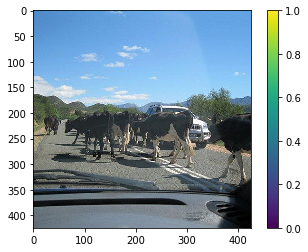

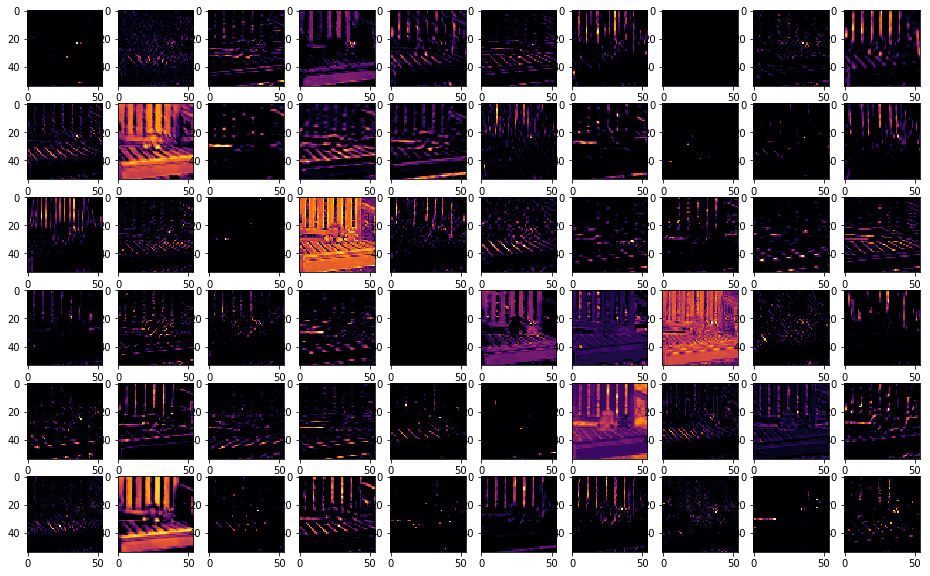

In [48]:
#okay now let's check the conv1 outputs to the images instead of the filters themselves
conv1_outputs = model.layers['conv1']
conv1_outputs = sess.run(conv1_outputs)
print(conv1_outputs.shape)

for image_idx in [-1]:
    plt.figure()

    plt.imshow(images[:,:,:])
    plt.colorbar()

    fav_image = conv1_outputs[image_idx,:,:,:]
    fav_image = np.moveaxis(fav_image, -1, 0) #put num of features in first column

    fig = plt.figure(figsize=(16,10))

    for idx in range(60):
        ax = fig.add_subplot(6, 10, idx+1) 
        ax.imshow(fav_image[idx,:,:], cmap="inferno")

In [19]:
all_ids = []
which_reps = []
id_nums_3reps = []
mask_3reps = []
for sidx, sid in enumerate(subjid):
    data = pd.read_csv('/oak/stanford/groups/kalanit/biac2/kgs/projects/Dawn/NSD/data/nsddata/ppdata/subj' + sid + '/behav/responses.tsv', sep='\t')
    
    all_ids.append(np.array(data['73KID']))
    
    vals, idx_start, count = np.unique(all_ids[sidx], return_counts=True, return_index=True)
    which_reps.append(vals[count == n_repeats])
    
    mask_3reps.append(np.isin(all_ids[sidx],which_reps[sidx]))
    id_nums_3reps.append(np.array(data['73KID'])[mask_3reps[sidx]])

In [20]:
s2_vals = np.unique(id_nums_3reps[1])

In [30]:
s2_vals

array([    6,    37,    45, ..., 72958, 72964, 72974])

In [21]:
s2_stim = stim['imgBrick'][s2_vals,:,:,:]

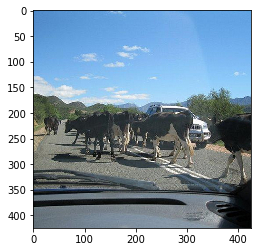

In [32]:
plt.imshow(s2_stim[-1,:,:,:])

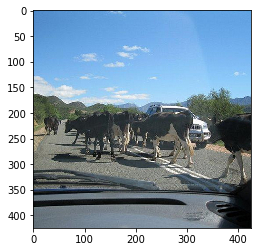

In [33]:
plt.imshow(stim['imgBrick'][72974,:,:,:])

In [23]:
10000/500

20

In [22]:
num_train_batch = 20
stim_set = []
layer_keys = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'fc6', 'fc7']
total_outputs = {}

In [34]:
idx = 0

In [35]:
test = s2_stim[500*idx:500*(idx+1),:,:,:]

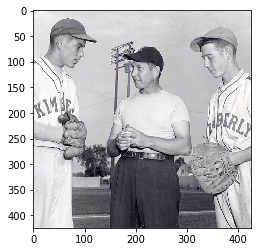

In [36]:
plt.imshow(test[0,:,:,:])

In [24]:
s2_vals

array([    6,    37,    45, ..., 72958, 72964, 72974])

In [23]:
# now let's do this for all the training images, not just the first batch, and for all layers

for idx in range(0,num_train_batch):
    
    print(idx)
    
    batch_images = s2_stim[500*idx:500*(idx+1),:,:,:]/255.0 #minibatch to start
    
    #create image tensor
    batch_image_tensor = tf.convert_to_tensor(batch_images, dtype=tf.float32)
    #resize for alexnet
    batch_resized_images = tf.image.resize_images(batch_image_tensor, (224, 224))
    
    # initialize model
    batch_convnet = alexnet(batch_resized_images)
    
    with tf.Session() as sess:
        tf_saver = tf.train.Saver()
        tf_saver.restore(sess, CKPT_PATH) #restore checkpoint weights

        for layer in layer_keys:
            print(layer)
            # define output tensors of interest
            batch_outputs = batch_convnet.layers[layer]

            # run whatever tensors we care about
            batch_outputs = sess.run(batch_outputs)

            if idx == 0:
                total_outputs[layer] = batch_outputs
            else:
                total_outputs[layer] = np.concatenate((total_outputs[layer],batch_outputs),axis=0)

            print(total_outputs[layer].shape)

0
INFO:tensorflow:Restoring parameters from ../models/checkpoints/alexnet/model.ckpt-115000
conv1
(500, 54, 54, 96)
conv2
(500, 27, 27, 256)
conv3
(500, 14, 14, 384)
conv4
(500, 14, 14, 384)
conv5
(500, 14, 14, 256)
fc6
(500, 4096)
fc7
(500, 4096)
1
INFO:tensorflow:Restoring parameters from ../models/checkpoints/alexnet/model.ckpt-115000
conv1
(1000, 54, 54, 96)
conv2
(1000, 27, 27, 256)
conv3
(1000, 14, 14, 384)
conv4
(1000, 14, 14, 384)
conv5
(1000, 14, 14, 256)
fc6
(1000, 4096)
fc7
(1000, 4096)
2
INFO:tensorflow:Restoring parameters from ../models/checkpoints/alexnet/model.ckpt-115000
conv1
(1500, 54, 54, 96)
conv2
(1500, 27, 27, 256)
conv3
(1500, 14, 14, 384)
conv4
(1500, 14, 14, 384)
conv5
(1500, 14, 14, 256)
fc6
(1500, 4096)
fc7
(1500, 4096)
3
INFO:tensorflow:Restoring parameters from ../models/checkpoints/alexnet/model.ckpt-115000
conv1
(2000, 54, 54, 96)
conv2
(2000, 27, 27, 256)
conv3
(2000, 14, 14, 384)
conv4
(2000, 14, 14, 384)
conv5
(2000, 14, 14, 256)
fc6
(2000, 4096)
fc7


KeyboardInterrupt: 

In [ ]:
#let's save the features as h5py to use for fitting in another notebook
h5f = h5py.File('../models/features/alexnet_features_subj02.h5', 'w')
for k, v in total_outputs.items():
    h5f.create_dataset(str(k), data=v)